# model

In [255]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

In [ ]:
        'active-defrag-threshold-lower',
        'save0_0',
        'save1_0',
        'save2_1',
        'maxmemory',
        'maxmemory-samples',
        'hz',
        
        'rdbcompression',
        'lazyfree-lazy-eviction',
        'lazyfree-lazy-server-del',
        'activerehashing',
        'dynamic-hz',

In [338]:
# knob 종류 및 바운드
['yes', 32, 'yes', 700, 355, 9577, 'no', 1, 2900, 7, 'no', 'no']
knobs_rdb = {
    
#     "hash-max-ziplist-entries":     (256, 751), 
#     "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
#     "save0_1": (1,9),
    "save1_0": (100,500),
#     "save1_1": (10,100),
#     "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
#     "rdbchecksum": ('yes', 'no'),    ##yes
#     "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

#     "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
#     "active-defrag-threshold-upper": (70, 101),
#     "active-defrag-cycle-min": (1, 31),
#     "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
#     "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
#                              "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
#     "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [339]:
# config(knob) data
config_df = pd.read_csv("./data/result_config_6000_6.csv", sep=',')

# external(throughput) data
external_df = pd.read_csv("./data/external_metrics_6000_6.csv", sep=',')

In [340]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [341]:
dataset.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,805,5,178,...,5,no,yes,yes,258,253,no,7,yes,61645.41
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1097,3,499,...,3,yes,yes,yes,360,226,yes,32,yes,63270.32
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1018,2,497,...,3,yes,yes,yes,364,136,yes,40,no,63602.49


In [342]:
# 결측치 처리 
dataset_nan = dataset.copy()
dataset['activedefrag'].fillna(value='no', inplace=True)  # activedefrag no 채우기
dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

In [343]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

In [344]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [345]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [346]:
# 결측치 처리전 확인
print(dataset_nan.info())

# 결측치 처리후 확인
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   appendonly                     0 non-null      float64
 1   appendfsync                    0 non-null      float64
 2   auto-aof-rewrite-percentage    0 non-null      float64
 3   auto-aof-rewrite-min-size      0 non-null      float64
 4   no-appendfsync-on-rewrite      0 non-null      float64
 5   aof-rewrite-incremental-fsync  0 non-null      float64
 6   aof-use-rdb-preamble           0 non-null      float64
 7   save0_0                        2500 non-null   int64  
 8   save0_1                        2500 non-null   int64  
 9   save1_0                        2500 non-null   int64  
 10  save1_1                        2500 non-null   int64  
 11  save2_0                        2500 non-null   int64  
 12  save2_1                        2500 non-null   i

### 이상치 처리

In [347]:
# -999999와 같은 이상치 확인 -> 없음
dataset.describe()

,hz,save0_0,save1_0,save2_1,active-defrag-threshold-lower,maxmemory,maxmemory-samples,throughput
count,2500.00000,2500.000000,2500.00000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000
mean,20.28280,895.984000,301.26200,9979.238400,7.83080,1950.880000,4.990000,58662.946124
std,11.68667,116.627749,116.01361,1168.360083,9.87832,583.036189,1.407229,3374.542926
min,1.00000,700.000000,100.00000,8000.000000,0.00000,1000.000000,3.000000,47520.430000
25%,10.00000,794.000000,202.00000,8957.250000,0.00000,1400.000000,4.000000,55643.050000
50%,20.00000,891.000000,302.00000,9958.500000,1.00000,2000.000000,5.000000,59031.920000
75%,31.00000,997.000000,402.00000,10999.500000,16.00000,2500.000000,6.000000,61586.640000
max,40.00000,1100.000000,500.00000,11996.000000,30.00000,2900.000000,7.000000,66377.650000


<AxesSubplot:>

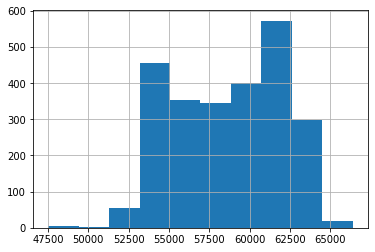

In [348]:
# 이상치 파악 
dataset['throughput'].hist()

In [349]:
# 인덱스제거하고 돌려보자
print(dataset['throughput'][dataset['throughput'] <= 52500])
outlier_index = dataset['throughput'][dataset['throughput'] <= 52500].index
print('개수: ', len(outlier_index))

289     50567.71
1662    48151.93
1795    47520.43
1819    52479.91
1829    52219.64
1869    52156.25
1871    52365.91
1872    52402.46
1918    49023.47
1941    52407.46
1972    52470.66
1994    51419.62
2277    48485.40
2400    50734.14
2437    47543.22
Name: throughput, dtype: float64
개수:  15


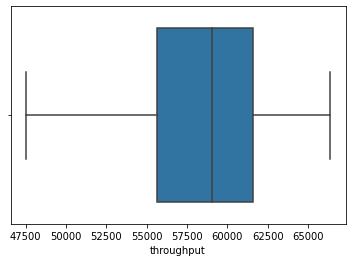

In [350]:
# 이상치로 분류되진 않지만 제거한다. 
import seaborn as sns
sns.boxplot(x = "throughput",data = dataset )
plt.show()

In [351]:
# # 이상치 제거
# dataset = dataset.drop(outlier_index)

In [352]:
# 이상치 제거 확인
dataset.shape

(2500, 13)

### test, train 데이터 분리

In [353]:
# test, train 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,:-1]
                                                    , dataset['throughput'] 
                                                    ,test_size=0.2
                                                   , random_state = 156)


In [354]:
# X_train 확인
X_train.head()

,activerehashing,hz,dynamic-hz,save0_0,save1_0,save2_1,rdbcompression,active-defrag-threshold-lower,maxmemory,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-server-del
1716,yes,29,yes,838,205,10529,yes,0.0,2600,3,no,no
486,yes,32,no,795,193,11917,no,0.0,2700,4,yes,no
1803,yes,23,yes,1100,497,8122,yes,0.0,2400,3,no,yes
1279,yes,33,no,735,209,11753,yes,0.0,2300,5,no,no
1642,no,39,no,818,255,10283,no,0.0,1500,3,no,yes


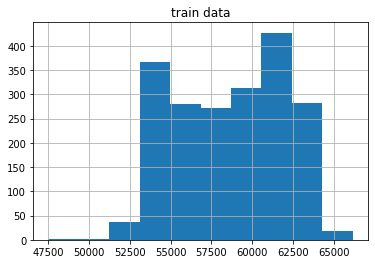

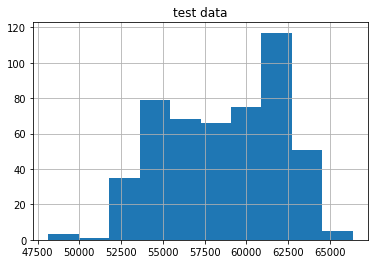

In [355]:
# test, train 에 비슷하게 분류됬는지 확인
y_train.hist()
plt.title('train data')
plt.show()

y_test.hist()
plt.title('test data')
plt.show()

## LightGBM 모델 생성

In [357]:
# 모델 객체 생성, n_estimators = 400으로 설정
lgbm_wrapper = LGBMRegressor(n_estimators=1000, learning_rate=0.1)

# 검증 데이터(validation data)
evals = [(X_test, y_test)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc',
                eval_set = evals, verbose = True)

[1]	valid_0's auc: 1	valid_0's l2: 1.21936e+07
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 1	valid_0's l2: 1.21977e+07
[3]	valid_0's auc: 1	valid_0's l2: 1.21989e+07
[4]	valid_0's auc: 1	valid_0's l2: 1.2209e+07
[5]	valid_0's auc: 1	valid_0's l2: 1.22038e+07
[6]	valid_0's auc: 1	valid_0's l2: 1.22096e+07
[7]	valid_0's auc: 1	valid_0's l2: 1.22696e+07
[8]	valid_0's auc: 1	valid_0's l2: 1.22963e+07
[9]	valid_0's auc: 1	valid_0's l2: 1.23191e+07
[10]	valid_0's auc: 1	valid_0's l2: 1.23359e+07
[11]	valid_0's auc: 1	valid_0's l2: 1.23688e+07
[12]	valid_0's auc: 1	valid_0's l2: 1.2392e+07
[13]	valid_0's auc: 1	valid_0's l2: 1.23674e+07
[14]	valid_0's auc: 1	valid_0's l2: 1.23503e+07
[15]	valid_0's auc: 1	valid_0's l2: 1.23411e+07
[16]	valid_0's auc: 1	valid_0's l2: 1.23568e+07
[17]	valid_0's auc: 1	valid_0's l2: 1.235e+07
[18]	valid_0's auc: 1	valid_0's l2: 1.23953e+07
[19]	valid_0's auc: 1	valid_0's l2: 1.2408e+07
[20]	valid_0's auc: 1	valid_0's l2: 1.24

LGBMRegressor(n_estimators=1000)

In [358]:
preds = lgbm_wrapper.predict(X_test)  # 예측 결과
# pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]  # 예측 확률
preds

array([58701.31525365, 58676.7399116 , 58676.7399116 , 58673.76719134,
       58544.23641008, 58673.76719134, 58673.76719134, 58517.17446822,
       58673.76719134, 58701.31525365, 58732.0930921 , 58701.31525365,
       58701.31525365, 58693.03010285, 58701.31525365, 58676.7399116 ,
       58673.76719134, 58701.31525365, 58693.03010285, 58701.31525365,
       58701.31525365, 58522.53094503, 58720.23074878, 58673.76719134,
       58701.31525365, 58676.7399116 , 58556.36764358, 58673.76719134,
       58673.76719134, 58696.3302863 , 58544.23641008, 58701.31525365,
       58701.31525365, 58701.31525365, 58764.12253397, 58673.76719134,
       58788.30384062, 58701.31525365, 58673.76719134, 58521.23871755,
       58764.12253397, 58517.17446822, 58792.3037125 , 58673.76719134,
       58676.7399116 , 58673.76719134, 58788.30384062, 58673.76719134,
       58522.53094503, 58673.76719134, 58701.31525365, 58673.6074624 ,
       58673.76719134, 58701.31525365, 58858.24897305, 58701.31525365,
      

In [359]:
X_test.iloc[:1,:]

,activerehashing,hz,dynamic-hz,save0_0,save1_0,save2_1,rdbcompression,active-defrag-threshold-lower,maxmemory,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-server-del
1096,yes,34,no,1068,270,9047,no,0.0,1000,3,no,no


In [360]:
lgbm_wrapper.predict(X_test.iloc[3:4,:])

array([58673.76719134])

In [361]:
df_result_test2

NameError: name 'df_result_test2' is not defined

In [362]:
# lgbm_wrapper.predict(df_result_test2)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

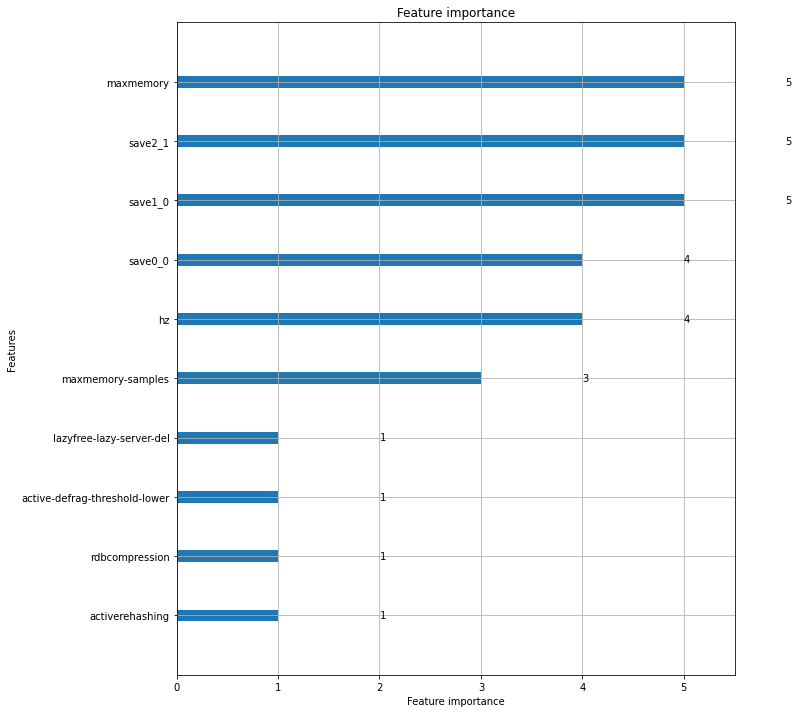

In [363]:
# plot_importance()를 이영해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax= ax)

In [364]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(y_test ,preds)
mse

12193580.638339631

### 하이퍼파라미터 튜닝

In [365]:
# from sklearn.model_selection import GridSearchCV

# # 하이퍼파라미터 튜닝시 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
# lgbm_wrapper = LGBMRegressor(n_estimators = 200)

# params = {
#     'num_leaves':[32, 64],
#     'max_depth':[128, 160],
#     'min_child_samples':[60, 100],
#     'subsample':[0.8, 1]
# }

# # cv는 3으로 가정 (교차 검증을 자동으로 해주는건가?)
# gridcv = GridSearchCV(lgbm_wrapper, param_grid = params, cv=3)
# gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric='auc', 
#           eval_set = [(X_train, y_train), (X_test, y_test)])

# print('GridSeaerchCV 최적 파라미터:', gridcv.best_params_)

In [366]:
# # 하이퍼 파라미터 적용 후 다시 생성
# lgbm_wrapper = LGBMRegressor(n_estimators = 1000,
#                             num_leaves = 32,
#                             subsample=0.8,
#                             min_child_samples=60,
#                             max_depth=128)

# evals = [(X_test, y_test)]

# lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
#                 eval_metric='auc',
#                 eval_set=evals,
#                 verbose=True)

---

# BO

## 목적함수

In [367]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):
    knob_dict = {}

    for i, knob in enumerate(knobs_list): # 딕셔너리로 이동
        knob_dict[knob] = knob_value[i]
    
#     # 고정

#     knob_dict['hash-max-ziplist-entries'] =305
#     knob_dict['hash-max-ziplist-value'] =157
#     knob_dict['activerehashing'] ='yes'
#     knob_dict['hz'] = 32
#     knob_dict['dynamic-hz'] ='yes'
#     knob_dict['save0_0'] = 722
#     knob_dict['save0_1'] = 5
#     knob_dict['save1_0'] = 475
#     knob_dict['save1_1'] =12
#     knob_dict['save2_0'] = 82
#     knob_dict['save2_1'] =9163
#     knob_dict['rdbcompression'] = 'no'
#     knob_dict['rdbchecksum'] = 'no'
#     knob_dict['rdb-save-incremental-fsync'] = 'no'
#     knob_dict['active-defrag-threshold-lower'] = 13
#     knob_dict['active-defrag-threshold-upper'] = 72
#     knob_dict['active-defrag-cycle-min'] = 2
#     knob_dict['active-defrag-cycle-max'] = 73
#     knob_dict['maxmemory'] = 1221
#     knob_dict["maxmemory-policy"] = 'allkeys-random'
#     knob_dict['maxmemory-samples'] =3
#     knob_dict['lazyfree-lazy-eviction'] = 'no'
#     knob_dict['lazyfree-lazy-expire'] = 'yes'
#     knob_dict['lazyfree-lazy-server-del'] = 'no'
        
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0     
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    # 카테고리 변수 변경
    for knob in category_knob:
        knob_df[knob] = knob_df[knob].astype('category') 

    return -lgbm_wrapper.predict(knob_df)[0]




## gp_minimize

In [368]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [384]:
res = gp_minimize(objective_func,                  # the function to minimize
                  knobs_bound,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=150,         # the number of evaluations of f
                  n_random_starts=20,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [385]:
res.x

['yes', 32, 'yes', 700, 355, 9577, 'no', 1, 2900, 7, 'no', 'no']

In [381]:
res.x_iters # 

[['no', 34, 'yes', 1009, 444, 8603, 'no', 25, 1302, 3, 'no', 'no'],
 ['no', 33, 'no', 722, 277, 8089, 'no', 8, 2403, 7, 'yes', 'no'],
 ['no', 19, 'yes', 1016, 286, 9741, 'yes', 30, 1077, 5, 'no', 'no'],
 ['no', 34, 'yes', 719, 498, 10757, 'yes', 29, 2853, 5, 'no', 'no'],
 ['yes', 25, 'no', 982, 166, 8129, 'no', 15, 1129, 5, 'no', 'yes'],
 ['yes', 16, 'no', 1063, 415, 10477, 'no', 10, 2257, 7, 'yes', 'no'],
 ['no', 1, 'no', 992, 492, 10760, 'yes', 22, 2801, 5, 'yes', 'no'],
 ['no', 39, 'yes', 891, 453, 9617, 'no', 5, 1783, 3, 'yes', 'yes'],
 ['no', 10, 'no', 872, 489, 8186, 'yes', 6, 2792, 6, 'no', 'no'],
 ['yes', 35, 'no', 976, 247, 11750, 'yes', 22, 1956, 6, 'no', 'yes'],
 ['yes', 19, 'no', 849, 473, 9675, 'no', 18, 2087, 5, 'yes', 'no'],
 ['yes', 20, 'yes', 1009, 111, 8884, 'no', 6, 1816, 6, 'yes', 'yes'],
 ['yes', 16, 'yes', 779, 440, 11842, 'no', 11, 1496, 6, 'no', 'no'],
 ['no', 15, 'no', 887, 361, 11989, 'yes', 13, 1111, 3, 'yes', 'no'],
 ['no', 1, 'no', 845, 348, 9676, 'no', 13,

In [382]:
res.func_vals

array([-58701.31525365, -58768.09993748, -58673.76719134, -58521.23871755,
       -58425.76351363, -58764.12253397, -58693.03010285, -58701.31525365,
       -58768.09993748, -58701.31525365, -58556.36764358, -58673.76719134,
       -58673.76719134, -58673.76719134, -58673.76719134, -58556.36764358,
       -58537.64017789, -58720.23074878, -58673.76719134, -58556.36764358,
       -58556.36764358, -58788.30384062, -58537.64017789, -58768.09993748,
       -58768.09993748, -58693.03010285, -58701.31525365, -58521.23871755,
       -58768.09993748, -58522.53094503, -58768.09993748, -58701.31525365,
       -58521.23871755, -58701.31525365, -58673.76719134, -58788.30384062,
       -58764.12253397, -58788.30384062, -58768.09993748, -58788.30384062,
       -58768.09993748, -58788.30384062, -58788.30384062, -58673.76719134,
       -58701.31525365, -58673.76719134, -58764.12253397, -58768.09993748,
       -58788.30384062, -58425.76351363, -58788.30384062, -58876.33437168,
       -58696.3302863 , -

In [386]:
res.fun

-58876.33437167593

일부:-58768.09993747965

전체: --58898.448123949456

* hash-max-ziplist-entries 504
* hash-max-ziplist-value 257
* activerehashing yes
* hz 2
* dynamic-hz no
* save 793 8
* save 500 26
* save 50 8694
* rdbcompression yes
* rdbchecksum yes
* rdb-save-incremental-fsync yes
* activedefrag no
* active-defrag-threshold-lower 1
* active-defrag-threshold-upper 101
* active-defrag-cycle-min 29
* active-defrag-cycle-max 70
* maxmemory 1000mb
* maxmemory-policy volatile-lfu
* maxmemory-samples 5
* lazyfree-lazy-eviction yes
* lazyfree-lazy-expire yes
* lazyfree-lazy-server-del no


In [337]:
res.x

[504,
 257,
 'yes',
 2,
 'no',
 793,
 8,
 500,
 26,
 50,
 8694,
 'yes',
 'yes',
 'yes',
 'no',
 1,
 101,
 29,
 70,
 1000,
 'volatile-lfu',
 5,
 'yes',
 'yes',
 'no']

---

In [127]:
# gp 결과 정리 함수
def li_to_str(result_list):
    for idx,knob in enumerate(list(knobs_rdb.keys())):  # knobs_rdb 키마다 접근
        print("{} ".format(knob), end='')
        print('{}'.format(result_list[idx]))

In [128]:
# gp 결과
li_to_str(res.x)

hash-max-ziplist-entries 308
hash-max-ziplist-value 257
activerehashing yes
hz 14
dynamic-hz yes


## gp 결과 정리

### gp 분류된것
"hash-max-ziplist-entries" : 284
'hash-max-ziplist-value' 22
'activerehashing': 'yes'
'hz' 32
'dynamic-hz' : 'yes'
'save0_0' : 877
'save0_1'2
'save1_0'272
'save1_1' : 12
'save2_0'33
'save2_1' : 11669 
'rdbcompression'no
'rdbchecksum' yes
"rdb-save-incremental-fsync" 'no'
'active-defrag-threshold-lower'3
'active-defrag-threshold-upper': 87
'active-defrag-cycle-min' : 25
'active-defrag-cycle-max' : 80
'maxmemory'1298
maxmemory-policy : 'allkeys-random' 
'maxmemory-samples'6
"lazyfree-lazy-eviction"  'no'
'lazyfree-lazy-expire' yes
'lazyfree-lazy-server-del' yes


### gp 분류된것2
hash-max-ziplist-entries 502
hash-max-ziplist-value 213
activerehashing yes
hz 32
dynamic-hz yes
save0_0 760
save0_1 3
save1_0 426
save1_1 24
save2_0 37
save2_1 8052 
rdbcompression no
rdbchecksum' no
rdb-save-incremental-fsync yes
active-defrag-threshold-lower 4
active-defrag-threshold-upper 72
active-defrag-cycle-min 14
active-defrag-cycle-max 70
maxmemory 1552
maxmemory-policy allkeys-random
maxmemory-samples 6
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no
[575,
 94,
 'no',
 10,
 'yes',
 1072,
 5,
 465,
 24,
 83,
 9398,
 'yes',
 'yes',
 'no',
 26,
 81,
 20,
 75,
 1539,
 'allkeys-lfu',
 4,
 'yes',
 'no',
 'no']

### gp_T
hash-max-ziplist-entries 575
hash-max-ziplist-value 94
activerehashing no
hz 10
dynamic-hz yes
save0_0 1072
save0_1 5
save1_0 465
save1_1 24
save2_0 83
save2_1 9398
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
active-defrag-threshold-lower 26
active-defrag-threshold-upper 81
active-defrag-cycle-min 20
active-defrag-cycle-max 75
maxmemory 1539
maxmemory-policy allkeys-lfu
maxmemory-samples 4
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del no

